# Empirical Questions

In [149]:
# Libraries
import pandas as pd
import numpy as np
import datetime
from dateutil.relativedelta import relativedelta
import math
import scipy.interpolate
import matplotlib.pyplot as plt

## Load data in

In [227]:
df = pd.read_csv('bond_data.csv', index_col = 0)
df['maturity_date'] = pd.to_datetime(df['maturity_date'])
df['date'] = pd.to_datetime(df['date'])
df[['bid','ask']] = df[['bid','ask']].replace('-','NaN').astype(float)
df = df.dropna()
df['close'] = (df['bid'] + df['ask'])/2

# pd.pivot_table(df, values = 'close', index = ['name', 'maturity_date', 'coupon'])
dfs = []
selected_bonds = ['CAN 1.75 Mar 23', 'CAN 0.25 Aug 23', 'CAN 2.25 Mar 24',  'CAN 1.50 Sep 24', 
                  'CAN 1.25 Mar 25', 'CAN 0.50 Sep 25', 'CAN 0.25 Mar 26', 'CAN 1.00 Sep 26', 
                  'CAN 1.25 Mar 27', 'CAN 2.75 Sep 27']

for i in range(5): #this
    dfs.append(df[(df['date'] == f'2023-01-{16+i}') & (df['name'].isin(selected_bonds)) ])
for i in range(5): 
    dfs.append(df[(df['date'] == f'2023-01-{23+i}') & (df['name'].isin(selected_bonds)) ])
dfs[0]

,bid,ask,maturity_date,bond_yield,coupon,name,date,close
126,98.70,100.71,2023-03-01,4.30%,1.7500%,CAN 1.75 Mar 23,2023-01-16,99.705
127,96.91,98.92,2024-03-01,4.19%,2.2500%,CAN 2.25 Mar 24,2023-01-16,97.915
130,95.38,97.40,2024-09-01,3.82%,1.5000%,CAN 1.50 Sep 24,2023-01-16,96.390
136,94.20,96.22,2025-03-01,3.63%,1.2500%,CAN 1.25 Mar 25,2023-01-16,95.210
138,89.87,91.89,2026-03-01,3.36%,0.2500%,CAN 0.25 Mar 26,2023-01-16,90.880
139,92.51,92.56,2026-09-01,3.19%,1.0000%,CAN 1.00 Sep 26,2023-01-16,92.535
140,91.53,93.56,2025-09-01,3.51%,0.5000%,CAN 0.50 Sep 25,2023-01-16,92.545
143,91.98,94.01,2027-03-01,3.07%,1.2500%,CAN 1.25 Mar 27,2023-01-16,92.995
148,97.78,97.79,2023-08-01,4.49%,0.2500%,CAN 0.25 Aug 23,2023-01-16,97.785
151,97.93,99.95,2027-09-01,2.99%,2.7500%,CAN 2.75 Sep 27,2023-01-16,98.940


We gathered bond data from https://markets.businessinsider.com/bonds/finder?borrower=71&maturity=shortterm&yield=&bondtype=2%2c3%2c4%2c16&coupon=&currency=184&rating=&country=19 for a period of 10 days. 10 of these bonds have been selected for us to work on and we store them in dfs, an array of pandas dataframes each representing one day of scraped data containing information about our 10 selected bonds

### 4.
### 4a) Yield Curve
(10 points) First, calculate each of your 10 selected bonds’ yield (ytm). Then provide a well labeled
plot with a 5-year yield curve (ytm curve) corresponding to each day of data superimposed
on-top of each other. You may use any interpolation technique you deem appropriate
provided you include a reasonable explanation for the technique used.

### Calculating yield to maturity (YTM) for zero coupon bonds

For a zero coupon bond, the bond will only contain a single cash flow (payment at maturity) and will be characterized by only 3 variables
- Notional (payment at maturity) N = Face value + final coupon payment
- Price of bond P
- Time to maturity T

### $$r(T) = -\frac{log(P/N)}{T}$$

In [228]:
# adding time to maturity to our data

def ttm(maturity, date):
    delta = relativedelta(maturity, date)
    return delta.years + delta.months/12 + delta.days/365

for df in dfs:
    df['ttm'] = df.apply(lambda row: ttm(row['maturity_date'],row['date']), axis = 1)
    df.sort_values(by = ['maturity_date'], ignore_index = True, inplace = True)
dfs[0]

,bid,ask,maturity_date,bond_yield,coupon,name,date,close,ttm
0,98.70,100.71,2023-03-01,4.30%,1.7500%,CAN 1.75 Mar 23,2023-01-16,99.705,0.118950
1,97.78,97.79,2023-08-01,4.49%,0.2500%,CAN 0.25 Aug 23,2023-01-16,97.785,0.543836
2,96.91,98.92,2024-03-01,4.19%,2.2500%,CAN 2.25 Mar 24,2023-01-16,97.915,1.121689
3,95.38,97.40,2024-09-01,3.82%,1.5000%,CAN 1.50 Sep 24,2023-01-16,96.390,1.627169
4,94.20,96.22,2025-03-01,3.63%,1.2500%,CAN 1.25 Mar 25,2023-01-16,95.210,2.118950
5,91.53,93.56,2025-09-01,3.51%,0.5000%,CAN 0.50 Sep 25,2023-01-16,92.545,2.627169
6,89.87,91.89,2026-03-01,3.36%,0.2500%,CAN 0.25 Mar 26,2023-01-16,90.880,3.118950
7,92.51,92.56,2026-09-01,3.19%,1.0000%,CAN 1.00 Sep 26,2023-01-16,92.535,3.627169
8,91.98,94.01,2027-03-01,3.07%,1.2500%,CAN 1.25 Mar 27,2023-01-16,92.995,4.118950
9,97.93,99.95,2027-09-01,2.99%,2.7500%,CAN 2.75 Sep 27,2023-01-16,98.940,4.627169


In [229]:
# calculate ytm of all 0 coupon bonds (ttm < 0.5) located in first row of each df in dfs
for df in dfs:
    df.insert(len(df.columns), "ytm", " ")
    coupon = float(df.iloc[0]['coupon'][:-2])/2
    # print(coupon)
    df.at[0, 'ytm'] = -(np.log(df.iloc[0]['close']/(100+coupon))/df.iloc[0]['ttm'])
dfs[1]

,bid,ask,maturity_date,bond_yield,coupon,name,date,close,ttm,ytm
0,98.71,100.72,2023-03-01,4.27%,1.7500%,CAN 1.75 Mar 23,2023-01-17,99.715,0.116210,0.099527
1,97.77,97.78,2023-08-01,4.49%,0.2500%,CAN 0.25 Aug 23,2023-01-17,97.775,0.541096,
2,96.92,98.93,2024-03-01,4.18%,2.2500%,CAN 2.25 Mar 24,2023-01-17,97.925,1.118950,
3,95.48,97.49,2024-09-01,3.77%,1.5000%,CAN 1.50 Sep 24,2023-01-17,96.485,1.624429,
4,94.38,96.41,2025-03-01,3.55%,1.2500%,CAN 1.25 Mar 25,2023-01-17,95.395,2.116210,
5,91.75,93.77,2025-09-01,3.44%,0.5000%,CAN 0.50 Sep 25,2023-01-17,92.760,2.624429,
6,90.10,92.11,2026-03-01,3.31%,0.2500%,CAN 0.25 Mar 26,2023-01-17,91.105,3.116210,
7,92.71,92.76,2026-09-01,3.16%,1.0000%,CAN 1.00 Sep 26,2023-01-17,92.735,3.624429,
8,92.15,94.19,2027-03-01,3.05%,1.2500%,CAN 1.25 Mar 27,2023-01-17,93.170,4.116210,
9,98.10,100.12,2027-09-01,2.96%,2.7500%,CAN 2.75 Sep 27,2023-01-17,99.110,4.624429,


### Calculating YTM of all other bonds
We can calculate the yield of all bonds based on a general formula which discounts the cashflows of the bond based on a single yield (discount rate).

### $$P = \sum_{i}^{n} p_i e^{-rt_i}$$

- $P$ = price taken from market (dirty price)
- $n$ = time steps
- $p_i$ = cash flow at period i. at i=n, cash flow = face value + final coupon payment
- $t_i$ = time to cashflow (steps of 6 months), $t_n$ = time to maturity
- $r$ = YTM  

We can actually solve this using a vectorized operation but that is a fun activity for another day

In [230]:
# guess and check algorithm to find YTM by discounting cashflows and equating to current market price

def calculate_price(periods: int, coupon: float, face_value: float, ttm: float, ytm: float) -> float:
    """
    :periods: the number of cashflows you get. e.g. periods = 2 -> 1 coupon payment + final nominal
    """
    price = 0
    for i in range(1, periods):
        ti = ttm - 0.5*i
        price += coupon * math.exp(-ytm * ti)
    # add final cashflow
    price += (coupon + face_value) * math.exp(-ytm * ttm)
    return price

def calculate_yield(periods: int, coupon: float, face_value: float, price: float,
                    ttm: float, error : float = 0.01) -> float:
    calculated_price = float('inf')
    ytm = 0.02
    ytm_step = 0.005
    decrease_flag = None
    
    while abs(calculated_price - price) > error :
        # update ytm
        if calculated_price > price: # ytm should increase
            # update ytm_step
            if decrease_flag:
                ytm_step /= 2
            ytm += ytm_step
            
        else: # ytm should decrease
            # update ytm_step
            if not decrease_flag:
                ytm_step /= 2
            ytm -= ytm_step
            
        # calculate calculated_price using updated ytm
        calculated_price = calculate_price(periods, coupon, face_value, ttm, ytm)
        
    return ytm


In [231]:
# calculate ytms for all other bonds
for df in dfs:
    for i in range(1,10):
        c = float(df.iloc[i]['coupon'][:-2])/2  # divide by 2 because this coupon is paid twice a year
        fv = 100
        tn = df.iloc[i]['ttm']
        P = df.iloc[i]['close']
        
        df.at[i, 'ytm'] = calculate_yield(periods = i+1, coupon = c, face_value = fv, price = P,
                    ttm = tn, error = 0.000001)
        
for df in dfs:
    df['ytm'] = df['ytm'] * 100
dfs[1]

,bid,ask,maturity_date,bond_yield,coupon,name,date,close,ttm,ytm
0,98.71,100.72,2023-03-01,4.27%,1.7500%,CAN 1.75 Mar 23,2023-01-17,99.715,0.116210,9.952676
1,97.77,97.78,2023-08-01,4.49%,0.2500%,CAN 0.25 Aug 23,2023-01-17,97.775,0.541096,4.625301
2,96.92,98.93,2024-03-01,4.18%,2.2500%,CAN 2.25 Mar 24,2023-01-17,97.925,1.118950,4.913507
3,95.48,97.49,2024-09-01,3.77%,1.5000%,CAN 1.50 Sep 24,2023-01-17,96.485,1.624429,4.078573
4,94.38,96.41,2025-03-01,3.55%,1.2500%,CAN 1.25 Mar 25,2023-01-17,95.395,2.116210,3.736859
5,91.75,93.77,2025-09-01,3.44%,0.5000%,CAN 0.50 Sep 25,2023-01-17,92.760,2.624429,3.456074
6,90.10,92.11,2026-03-01,3.31%,0.2500%,CAN 0.25 Mar 26,2023-01-17,91.105,3.116210,3.283223
7,92.71,92.76,2026-09-01,3.16%,1.0000%,CAN 1.00 Sep 26,2023-01-17,92.735,3.624429,3.225434
8,92.15,94.19,2027-03-01,3.05%,1.2500%,CAN 1.25 Mar 27,2023-01-17,93.170,4.116210,3.132811
9,98.10,100.12,2027-09-01,2.96%,2.7500%,CAN 2.75 Sep 27,2023-01-17,99.110,4.624429,3.174822


### Interpolation
Now that we have calculated the yield to maturity of our 10 selected bonds spaced approximately 6 months apart, we can interpolate the yields for every other month in our yield curve  
  
To handle this task, we will use the scipy.interpolate.CubicSpline method. This will allow us to interpolate the data with a piecewise cubic polynomial

In [232]:
ytms = []
ttms = []

for df in dfs:
    ytms.append(df['ytm'])
    ttms.append(df['ttm'])

X = np.linspace(0,5,20)
interpolated_ytms = []
for ytm,ttm in zip(ytms,ttms):
    cs = scipy.interpolate.CubicSpline(x = ttm, y = ytm, bc_type = 'not-a-knot')
    output_data = cs(X)
    interpolated_ytms.append(output_data)
interpolated_ytms[0]

array([13.0422    ,  7.06416793,  4.65186415,  4.3858237 ,  4.84658161,
        4.76374472,  4.21959148,  3.91375854,  3.82939094,  3.70027829,
        3.53898216,  3.42128015,  3.35238514,  3.31430234,  3.27253327,
        3.21210629,  3.16527144,  3.17033155,  3.26558948,  3.48934803])

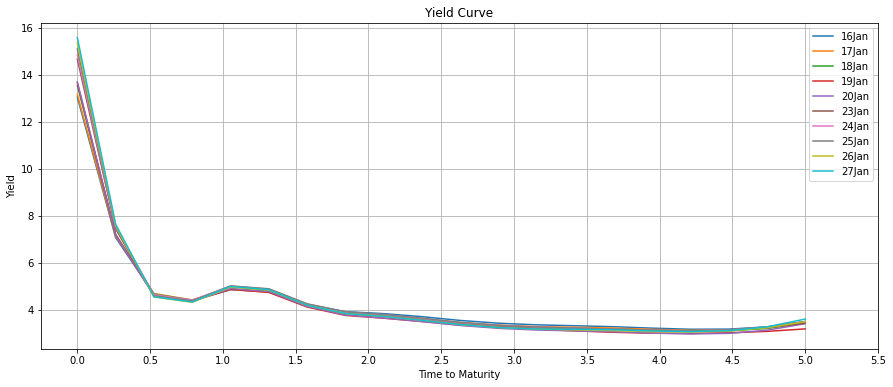

In [240]:
dates = ["16Jan", "17Jan", "18Jan", "19Jan", "20Jan", "23Jan", "24Jan", "25Jan", "26Jan", "27Jan"]
plt.figure(figsize=(15,6))

for ytm,date in zip(interpolated_ytms, dates):
    plt.plot(X, ytm, label= date)

plt.xlabel('Time to Maturity')
plt.ylabel('Yield')
plt.title('Yield Curve')
plt.grid(True)
plt.xticks(np.arange(min(x), max(x)+1, 0.5))
plt.legend()
plt.show()

### Inverted Yield Curve! What does this mean?
An inverted yield curve occurs when the interest rates on long-term debt instruments are lower than the interest rates on short-term debt instruments, which is the opposite of the typical relationship between rates and maturity. This phenomenon is considered a strong predictor of a future recession, as investors often demand a higher return for longer-term investments due to increased uncertainty. An inverted yield curve can also indicate that the market is expecting lower future economic growth and inflation. This sentiment is inline with the current global economic outlook due to the severe economic impact the COVID-19 pandemic has had over the past few years.

### 4b) Spot Curve
(15 points) Write a pseudo-code (explanation of an algorithm) for how you would derive the
spot curve with terms ranging from 1-5 years from your chosen bonds in part 2. (Please recall
the day convention simplifications provided in part 2 as well.) Then provide a well-labeled plot
with a 5-year spot curve corresponding to each day of data superimposed on-top of each other.

Whereas the yield curve gives a yield that is used to discount multiple cash flows (i.e., all of the cash flows – coupons and principal – for a coupon-paying bond), the spot curve gives a yield that is used to discount a single cash flow at a given maturity (called a spot payment; hence: spot curve); it gives the YTM for zero-coupon (as opposed to coupon-paying) bonds.  Thus, to determine the price of a coupon-paying bond, instead of discounting all of the cash flows at the same rate – the bond’s YTM – you could discount the first coupon payment at the spot rate for its maturity, and the second coupon payment at the spot rate for its maturity, and so on.  The key that links the spot curve to the yield curve is that you have to get the same price whether you use the par curve or the spot curve (otherwise, there would be an arbitrage opportunity).  The spot curve is derived from the par curve with this relationship in mind.

A common use for the spot curve is in computing the Z-spread for a bond.  A constant spread is added to each point on the spot curve, and these modified discount rates are used to determine the price of the bond: the amount of the spread is adjusted until the discounted price equals the market price.  The spot curve is also used to develop the forward curve.

### Bootstrapping to calculate YTM of all other bonds
For all bonds maturing within 6 months, they are essentially zero coupon bonds and have spot rates equal to the yield curve. With the spot rates of zero coupon bonds maturing within 6 months, we can calculate the spot rates of bonds maturing between six months and one year with the following equations. For maturities between six months and one year, bonds have a coupon payment within six months and a final payment between six months and one year:
### $$P = p_1e^{-r(t_1)*t_1} + p_2e^{-r(t_2)*t_2}$$
Where $0<t_1<\frac{1}{2}<t_2<1$
- $P$ = price taken from market (dirty price)
- $p_1$ = coupon payment 6 months before maturity
- $t_1$ = 6 months before time to maturity
- $t_2$ = time to maturity
- $p_2$ = notional = face value ($100) + final coupon payment
  
This is essentially just a discount of all the cashflows of the bond and we can solve the one-variable equation:
### $$r(t_2) = \frac{lg(p_2)-lg(P-p_1 e^{-r(t_1)*t_1})}{t_2}$$

These equations are based on the general formula below which can be generalized for all bonds expiring further into the future:
### $$P = \sum_i p_i e^{-r(t_i)t_i}$$
### $$r(t_n) = \frac{lg(p_n)-lg(P - \sum_{i=1}^{n-1} p_i e^{-r(t_i)*t_i})}{t_n}$$
We can thus continue this process step by step for each time step of 6 months (1 coupon payment) into infinity

In [241]:
# calculate spot rates of all 0 coupon bonds (ttm < 0.5) located in first row of each df in dfs
# spot rate for 0 coupon bonds = ytm
for df in dfs:
    df.insert(len(df.columns), "spot", " ")
    coupon = float(df.iloc[0]['coupon'][:-2])/2
    # print(coupon)
    df.at[0, 'spot'] = -(np.log(df.iloc[0]['close']/(100+coupon))/df.iloc[0]['ttm'])
dfs[4]

,bid,ask,maturity_date,bond_yield,coupon,name,date,close,ttm,ytm,spot
0,98.74,100.75,2023-03-01,4.22%,1.7500%,CAN 1.75 Mar 23,2023-01-20,99.745,0.107991,10.43162,0.104316
1,97.84,97.85,2023-08-01,4.47%,0.2500%,CAN 0.25 Aug 23,2023-01-20,97.845,0.532877,4.562263,
2,96.92,98.93,2024-03-01,4.19%,2.2500%,CAN 2.25 Mar 24,2023-01-20,97.925,1.110731,4.950432,
3,95.54,97.55,2024-09-01,3.77%,1.5000%,CAN 1.50 Sep 24,2023-01-20,96.545,1.616210,4.060596,
4,94.59,96.64,2025-03-01,3.45%,1.2500%,CAN 1.25 Mar 25,2023-01-20,95.615,2.107991,3.640693,
5,92.07,94.09,2025-09-01,3.33%,0.5000%,CAN 0.50 Sep 25,2023-01-20,93.080,2.616210,3.334384,
6,90.52,92.54,2026-03-01,3.16%,0.2500%,CAN 0.25 Mar 26,2023-01-20,91.530,3.107991,3.141523,
7,93.25,93.30,2026-09-01,2.98%,1.0000%,CAN 1.00 Sep 26,2023-01-20,93.275,3.616210,3.069063,
8,92.77,94.81,2027-03-01,2.88%,1.2500%,CAN 1.25 Mar 27,2023-01-20,93.790,4.107991,2.973125,
9,98.68,100.70,2027-09-01,2.82%,2.7500%,CAN 2.75 Sep 27,2023-01-20,99.690,4.616210,3.045749,


In [242]:
# calculate spot rates for all other bonds

for df in dfs:
    for i in range(1,10):
        pi = float(df.iloc[i]['coupon'][:-2])/2 # divide by 2 because this coupon is paid twice a year
        pn = 100 + pi
        tn = df.iloc[i]['ttm']
        P = df.iloc[i]['close']
        
        sumTerm = 0
        for j in range(0,i):
            tj = (tn - 0.5 * (i - j) )  
            r_tj = df.iloc[j]['spot']
            sumTerm += pi*math.exp(-r_tj * tj)
        
        df.at[i, 'spot'] = ( (np.log(pn) - np.log(P - sumTerm))
                           /tn )
        
for df in dfs:
    df['spot'] = df['spot']*100
dfs[1]

,bid,ask,maturity_date,bond_yield,coupon,name,date,close,ttm,ytm,spot
0,98.71,100.72,2023-03-01,4.27%,1.7500%,CAN 1.75 Mar 23,2023-01-17,99.715,0.116210,9.952676,9.952676
1,97.77,97.78,2023-08-01,4.49%,0.2500%,CAN 0.25 Aug 23,2023-01-17,97.775,0.541096,4.625301,4.624785
2,96.92,98.93,2024-03-01,4.18%,2.2500%,CAN 2.25 Mar 24,2023-01-17,97.925,1.118950,4.913507,4.90909
3,95.48,97.49,2024-09-01,3.77%,1.5000%,CAN 1.50 Sep 24,2023-01-17,96.485,1.624429,4.078573,4.069054
4,94.38,96.41,2025-03-01,3.55%,1.2500%,CAN 1.25 Mar 25,2023-01-17,95.395,2.116210,3.736859,3.727328
5,91.75,93.77,2025-09-01,3.44%,0.5000%,CAN 0.50 Sep 25,2023-01-17,92.760,2.624429,3.456074,3.451348
6,90.10,92.11,2026-03-01,3.31%,0.2500%,CAN 0.25 Mar 26,2023-01-17,91.105,3.116210,3.283223,3.280657
7,92.71,92.76,2026-09-01,3.16%,1.0000%,CAN 1.00 Sep 26,2023-01-17,92.735,3.624429,3.225434,3.21545
8,92.15,94.19,2027-03-01,3.05%,1.2500%,CAN 1.25 Mar 27,2023-01-17,93.170,4.116210,3.132811,3.119724
9,98.10,100.12,2027-09-01,2.96%,2.7500%,CAN 2.75 Sep 27,2023-01-17,99.110,4.624429,3.174822,3.151261


### Interpolate and plot Spot Curve

[13.04210558  7.06414956  4.65138016  4.38422221  4.84310056  4.75761778
  4.21100908  3.90421338  3.82051627  3.69330385  3.53452017  3.41893983
  3.34954545  3.3075043   3.26182432  3.19964919  3.15090346  3.1509952
  3.2353325   3.43932343]


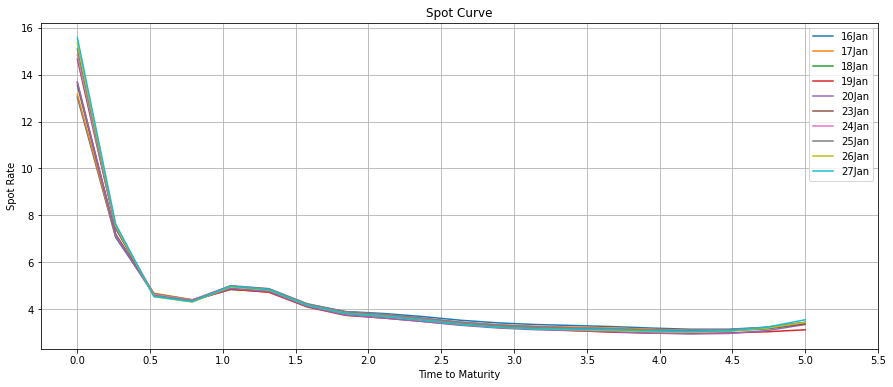

In [243]:
spots = []
ttms = []

for df in dfs:
    spots.append(df['spot'])
    ttms.append(df['ttm'])

X = np.linspace(0,5,20)
interpolated_spots = []
for spot,ttm in zip(spots,ttms):
    cs = scipy.interpolate.CubicSpline(x = ttm, y = spot, bc_type = 'not-a-knot')
    output_data = cs(X)
    interpolated_spots.append(output_data)
print(interpolated_spots[0])

dates = ["16Jan", "17Jan", "18Jan", "19Jan", "20Jan", "23Jan", "24Jan", "25Jan", "26Jan", "27Jan"]
plt.figure(figsize=(15,6))

for spot,date in zip(interpolated_spots, dates):
    plt.plot(X, spot, label = date)

plt.xlabel('Time to Maturity')
plt.ylabel('Spot Rate')
plt.title('Spot Curve')
plt.grid(True)
plt.xticks(np.arange(min(x), max(x)+1, 0.5))
plt.legend()
plt.show()

### 4c) Forward Curve
(15 points) Write a pseudo-code for how you would derive the 1-year forward curve with terms
ranging from 2-5 years from your chosen bonds in part 2 (I.e., a curve with the first point being
the 1yr-1yr forward rate and the last point being the 1yr-4yr rate). Then provide a well-labeled
plot with a forward curve corresponding to each day of data superimposed on-top of each other.

A forward interest rate acts as a discount rate for a single payment from one future date (for example, five years from now) and discounts it to a closer future date (for example, three years from now).

- $r_{0n}$ : spot rate from year 0 to year n
- $f_{1n}$ : forward rate from year 1 to year n
### $$e^{r_{01}*1} * e^{f_{1t}(t-1)} = e^{r_{0t}*t} $$
### $$ f_{1t} = \frac{r_{0t}*t - r_{01}}{t-1}$$

For this particuar question, we want the 1-year forward curve with forward rates 1yr-1yr, 1yr-2yr, 1yr-3yr, 1yr-4yr. These rates correspond to discount rates that discount cashflows from the nth year to 1 year from now. For this implementation, we will use the spot rate in march for each year that we calculated in the previous section.

In [273]:
# get march spot rates
march_spot_rates = []

for df in dfs:
    march_spot_rates.append(list(df[pd.DatetimeIndex(df['maturity_date']).month == 3]['spot']))

march_spot_rates[8]

[11.976160441466476,
 5.007382225863269,
 3.7102813153429977,
 3.1820774265201637,
 3.0361102672448457]

In [258]:
def calculate_forward_rate(r_0t: float, t: float, r_01: float):
    return (r_0t * t - r_01) / (t-1)
    

In [309]:
all_forward_rates = []

for spot_rates in march_spot_rates:
    r_01 = spot_rates[0]
    forward_rates = []
    
    for i in range(1, len(spot_rates)):
        forward_rate = calculate_forward_rate(r_0t = spot_rates[i], t = i+1, r_01 = r_01 )
        forward_rates.append(forward_rate)
    
    all_forward_rates.append(forward_rates)
    
all_forward_rates[0]

[0.005150578724068211,
 0.82037590457655,
 1.2073612073263356,
 1.5032253836455118]

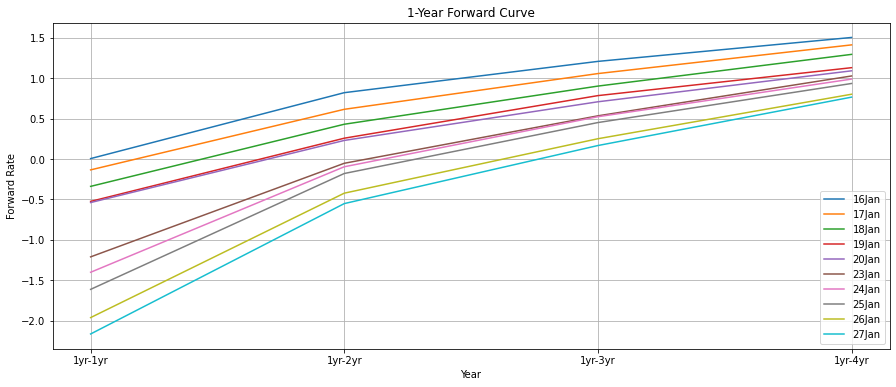

In [310]:
dates = ["16Jan", "17Jan", "18Jan", "19Jan", "20Jan", "23Jan", "24Jan", "25Jan", "26Jan", "27Jan"]
forward_curve_X = ["1yr-1yr", "1yr-2yr", "1yr-3yr", "1yr-4yr"]

plt.figure(figsize=(15,6))

for forward_rates,date in zip(all_forward_rates, dates):
    plt.plot(forward_curve_X, forward_rates, label = date)

plt.xlabel('Year')
plt.ylabel('Forward Rate')
plt.title('1-Year Forward Curve')
plt.grid(True)
plt.legend()
plt.show()

### 5 Covariance Matrices
(20 points) Calculate two covariance matrices for the time series of daily log-returns of yield, and
forward rates (no spot rates). In other words, first calculate the covariance matrix of the random
variables $X_i$, for i = 1, . . . , 5, where each random variable $X_i$ has a time series $X_{i,j}$ given by:
### $$X_{i,j} = log(r_{i,j+1}/r_{i,j}),  j = 1, . . . , 9$$
then do the same for the following forward rates - the 1yr-1yr, 1yr-2yr, 1yr-3yr, 1yr-4yr.

In [285]:
# construct a 5 x 10 matrix, 5 rows for each year (2023,2024,etc...)
# for every day we collected data (10)

# get march spot rates
march_yields = []

for df in dfs:
    march_yields.append(list(df[pd.DatetimeIndex(df['maturity_date']).month == 3]['ytm']))

march_yields[8]

[11.976160441466476,
 5.01175308227539,
 3.720558166503906,
 3.18493890762329,
 3.0498609542846684]

In [314]:
# for yields
yearly_yields = np.stack(march_yields).T # 5 x 10 matrix
print('5 x 10 Matrix of yearly yields')
print(yearly_yields)

# Calculate X 5 x 9 matrix of X_i,j as given in the formula above
yield_X = np.log(yearly_yields.T[1:]/yearly_yields.T[:-1]).T 
print('5 x 9 Matrix of random variables X_ij')
print(yield_X)

# Find covariance matrix
yield_cov = np.cov(yield_X)
print('Covariance matrix for time series of daily log-returns of yield')
print(yield_cov)

5 x 10 Matrix of yearly yields
[[ 9.80775353  9.95267622 10.23717373 10.35461694 10.43162042 11.29097587
  11.50646278 11.73448259 11.97616044 12.23276032]
 [ 4.91056633  4.91350746  4.95363045  4.91943741  4.95043182  5.04437828
   5.05714226  5.06524086  5.01175308  5.03878593]
 [ 3.82497025  3.73685932  3.70905304  3.63337898  3.64069271  3.73869133
   3.78171825  3.80199718  3.72055817  3.72042465]
 [ 3.35996437  3.28322315  3.23835278  3.17934132  3.14152336  3.2261014
   3.27162027  3.27453041  3.18493891  3.18599892]
 [ 3.17763472  3.13281107  3.09605646  2.98843956  2.97312546  3.09325647
   3.10614872  3.10828781  3.04986095  3.07215118]]
5 x 9 Matrix of random variables X_ij
[[ 1.46682332e-02  2.81840960e-02  1.14069227e-02  7.40911702e-03
   7.91621934e-02  1.89050471e-02  1.96228785e-02  2.03863069e-02
   2.11995810e-02]
 [ 5.98760095e-04  8.13269407e-03 -6.92655538e-03  6.28063380e-03
   1.87996016e-02  2.52714110e-03  1.60013782e-03 -1.06159199e-02
   5.37939653e-03]
 [-2

In [305]:
len(all_forward_rates)

10

In [315]:
# for forward rates
forward_yields = np.stack(all_forward_rates).T # 4 x 10 matrix
print('4 x 10 Matrix of forward yields')
print(forward_yields)

# Calculate X 4 x 9 matrix of X_i,j as given in the formula above
forward_X = np.log(abs(forward_yields.T[1:]/forward_yields.T[:-1])).T 
print('4 x 9 Matrix of random variables X_ij')
print(forward_X)

# # Find covariance matrix
forward_cov = np.cov(forward_X)
print('Covariance matrix for time series of daily log-returns of forward rates')
print(forward_cov)

4 x 10 Matrix of forward yields
[[ 0.00515058 -0.13449621 -0.33840815 -0.52433487 -0.53861271 -1.21039323
  -1.40085275 -1.61226921 -1.96139599 -2.16399077]
 [ 0.8203759   0.61465387  0.42997306  0.25731996  0.22960789 -0.05291455
  -0.09590128 -0.17921936 -0.42265825 -0.55142625]
 [ 1.20736121  1.05665116  0.90181576  0.78403722  0.7077556   0.53405185
   0.52296258  0.45080412  0.25071642  0.16657299]
 [ 1.50322538  1.41148636  1.29402179  1.12946878  1.0906444   1.02694361
   0.9885099   0.93405227  0.80109772  0.7650952 ]]
4 x 9 Matrix of random variables X_ij
[[ 3.26242693  0.9227167   0.43787782  0.02686625  0.80970378  0.14613587
   0.14056148  0.19601382  0.09829764]
 [-0.28870336 -0.35733674 -0.51340227 -0.11394726 -1.4676947   0.59464099
   0.62529121  0.8579534   0.26594417]
 [-0.13333253 -0.15844967 -0.13995374 -0.10235766 -0.2816059  -0.02098302
  -0.148477   -0.58671041 -0.40888892]
 [-0.06296975 -0.08688827 -0.13600762 -0.0349787  -0.06018169 -0.03814364
  -0.05666626 -0

### 6 Eigenvalues & Eigenvectors
(15 points) Calculate the eigenvalues and eigenvectors of both covariance matrices, and in one sentence,
explain what the first (in terms of size) eigenvalue and its associated eigenvector imply.

In [320]:
y_eigenvalues, y_eigenvectors = np.linalg.eig(yield_cov)
print('Eigenvalues of YTM log returns covariance matrix')
print(y_eigenvalues)
print('Eigenvectors of YTM log returns covariance matrix')
print(y_eigenvectors)

Eigenvalues of YTM log returns covariance matrix
[1.33374032e-03 1.65357652e-04 4.12971008e-05 9.46802635e-06
 2.02160276e-05]
Eigenvectors of YTM log returns covariance matrix
[[ 0.50708331  0.81494295  0.25256266 -0.10990062 -0.05355803]
 [ 0.19925215 -0.01398096 -0.34525166  0.41961298 -0.81537069]
 [ 0.43039271 -0.42536577  0.12844156 -0.72073987 -0.31283043]
 [ 0.45761469 -0.38175808  0.57830619  0.5366623   0.14968328]
 [ 0.55544217 -0.09485379 -0.68269914  0.0661394   0.46047174]]


In [319]:
f_eigenvalues, f_eigenvectors = np.linalg.eig(forward_cov)
print('Eigenvalues of forward log returns covariance matrix')
print(f_eigenvalues)
print('Eigenvectors of forward log returns covariance matrix')
print(f_eigenvectors)

Eigenvalues of forward log returns covariance matrix
[1.15329514 0.41781891 0.02985484 0.00129948]
Eigenvectors of forward log returns covariance matrix
[[-9.25240493e-01  3.78655456e-01  2.32502415e-02  3.08251285e-03]
 [ 3.77515788e-01  9.25044850e-01 -4.21153738e-02 -3.87029856e-04]
 [-3.75212930e-02 -2.98147200e-02 -9.89981227e-01 -1.32817186e-01]
 [-2.00305264e-03 -4.81175041e-03 -1.32751238e-01  9.91135684e-01]]


The first eigenvector corresponds to the directions of maximum variance in the data and its associated eigenvector indicates the percent of total variance explained by the eigenvector which can be calculated by $$x = \frac{v}{\sum_{i}{v_i}}$$ where x is the percent of total variance and $v_i$ is the ith eigenvalue. 